In [24]:
import numpy as np
import cv2
import os
import glob
import torch
from density import PDM, Delta
from matplotlib import pyplot as plt
from PIL import Image
import pickle
from tqdm import tqdm
results_path="./result/D06_20210115175538_i100_1.pth"
results=torch.load(results_path)
bim_floor = cv2.imread("base/target8F_L.png")
gt_path="result/gt/D06_20210115175538"
mask_path="base/mask-r"
H = np.load("base/7F_D06_1.npy")
def cal_single_gt(gt_path,mask,H):
    gt_list=glob.glob(gt_path+"/*.png")
    gt_list=sorted(gt_list, key=lambda x: int(os.path.splitext(os.path.basename(x))[0]))
    gt_dict={}
    A_mask=np.sum(mask>0)
    gt_sum=np.zeros_like(mask)
    for i in range(len(gt_list)):
        gt_i_raw=cv2.imread(gt_list[i],0)
        gt_i = cv2.warpPerspective(
                gt_i_raw, H, mask.shape[::-1], borderValue=0
            )
        gt_sum+=gt_i
        A_gt=np.sum((gt_sum*mask)>0)
        gt_dict[int(os.path.basename(gt_list[i]).split(".")[0])]=A_gt/A_mask
    # prev_value = None
    # for key in sorted(gt_dict.keys()):
    #     if prev_value is not None and gt_dict[key] < prev_value:
    #         gt_dict[key] = prev_value
    #     prev_value = gt_dict[key]
    return gt_dict
def cal_single_pred(mask_list,flag_map):
    percentage_list=[]
    for mask in mask_list:
        A_mask=np.sum(mask>0)
        A_pred=np.sum(flag_map*(mask>0)>0)
        percentage_list.append(A_pred/A_mask)
    return percentage_list
gt_list=[]
mask_list=[]
for mask_id in range(1,15):
    mask=cv2.imread(os.path.join(mask_path,f"{mask_id}.png"),0)
    gt_dict=cal_single_gt(gt_path=gt_path,mask=mask,H=H)
    gt_list.append(gt_dict)
    mask_list.append(mask)
all_mask = np.sum(mask_list, axis=0)>0


0


In [3]:
ids=range(0,len(results),50)
delta = Delta(img=bim_floor,shape=bim_floor.shape[:2],sigma=25)
density=np.zeros(bim_floor.shape[:2],dtype=np.float32)
pdm=PDM(density,alpha=1,frame_interval=100,T_need=30)
progress=[]
x=[0]
for id in tqdm(ids):
    delta.add_points_list(results[id:id+50])
    pdm.update_map(delta.get_raw(masked=True,process=True))
    map=pdm.get_PDM(clip=True)
    flag_map=pdm.get_flag()
    pred=cal_single_pred(mask_list,flag_map)
    progress.append(pred)
    x.append(x[-1]+len(results[id:id+50]))
x.pop(0)
x=[i+100 for i in x]

100%|██████████| 20/20 [00:31<00:00,  1.60s/it]


In [67]:
check_id_list=[7,8,9,10,11,12]
gt=[]
pred=[]
for id in check_id_list:
    sc_y=list(gt_list[id].values())
    y = [pred[id] for pred in progress][0:-1]
    gt.extend(sc_y)
    pred.extend(y)
print(f"Number of checked: {len(gt)}")
AE=0
max_AE=0
for g,p in zip(gt,pred):
    AE+=abs(g-p)
    max_AE=max(abs(g-p),max_AE)
print(f"Mean Absolute Error: {AE/len(gt)}")
print(f"Max Absolute Error: {max_AE}")


Number of checked: 114
Mean Absolute Error: 0.02891278458176066
Max Absolute Error: 0.10509269074034816


(0.0, 1.0)

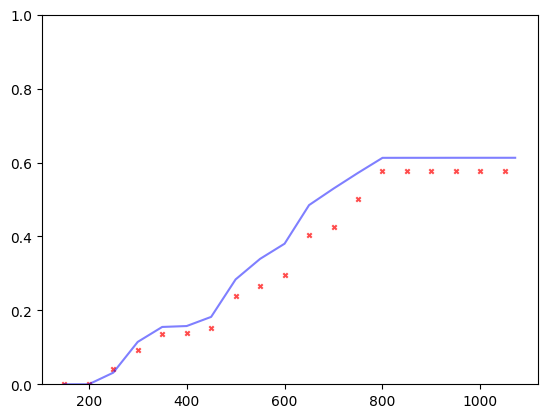

In [44]:
import matplotlib.pyplot as plt
import numpy as np
i=11
sc_x=[i/100 for i in gt_list[i].keys()]
sc_y=list(gt_list[i].values())
fig=plt.figure()
ax=fig.add_subplot(111)
y = [pred[i] for pred in progress]
plt.plot(x, y,alpha=0.5,color="blue")
plt.scatter(sc_x,sc_y,alpha=0.7,color="red",s=10,marker="x")
ax.set_ylim([0, 1])

/home/gaobiaoli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in double_scalars
/home/gaobiaoli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


[4.3249969482421875, 7.216486930847168, 0.9770439267158508, 0.00038099708035588264, 0.001802742131985724, 7.67678969282315e-08, 0.0, 1860.6942138671875, 1225.66357421875, 943.0885620117188]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 60929.0, 46293.0, 38073.0]
[inf, inf, inf, inf, inf, inf, nan, 3.0538728911802053, 2.647621830986866, 2.4770534552352554]


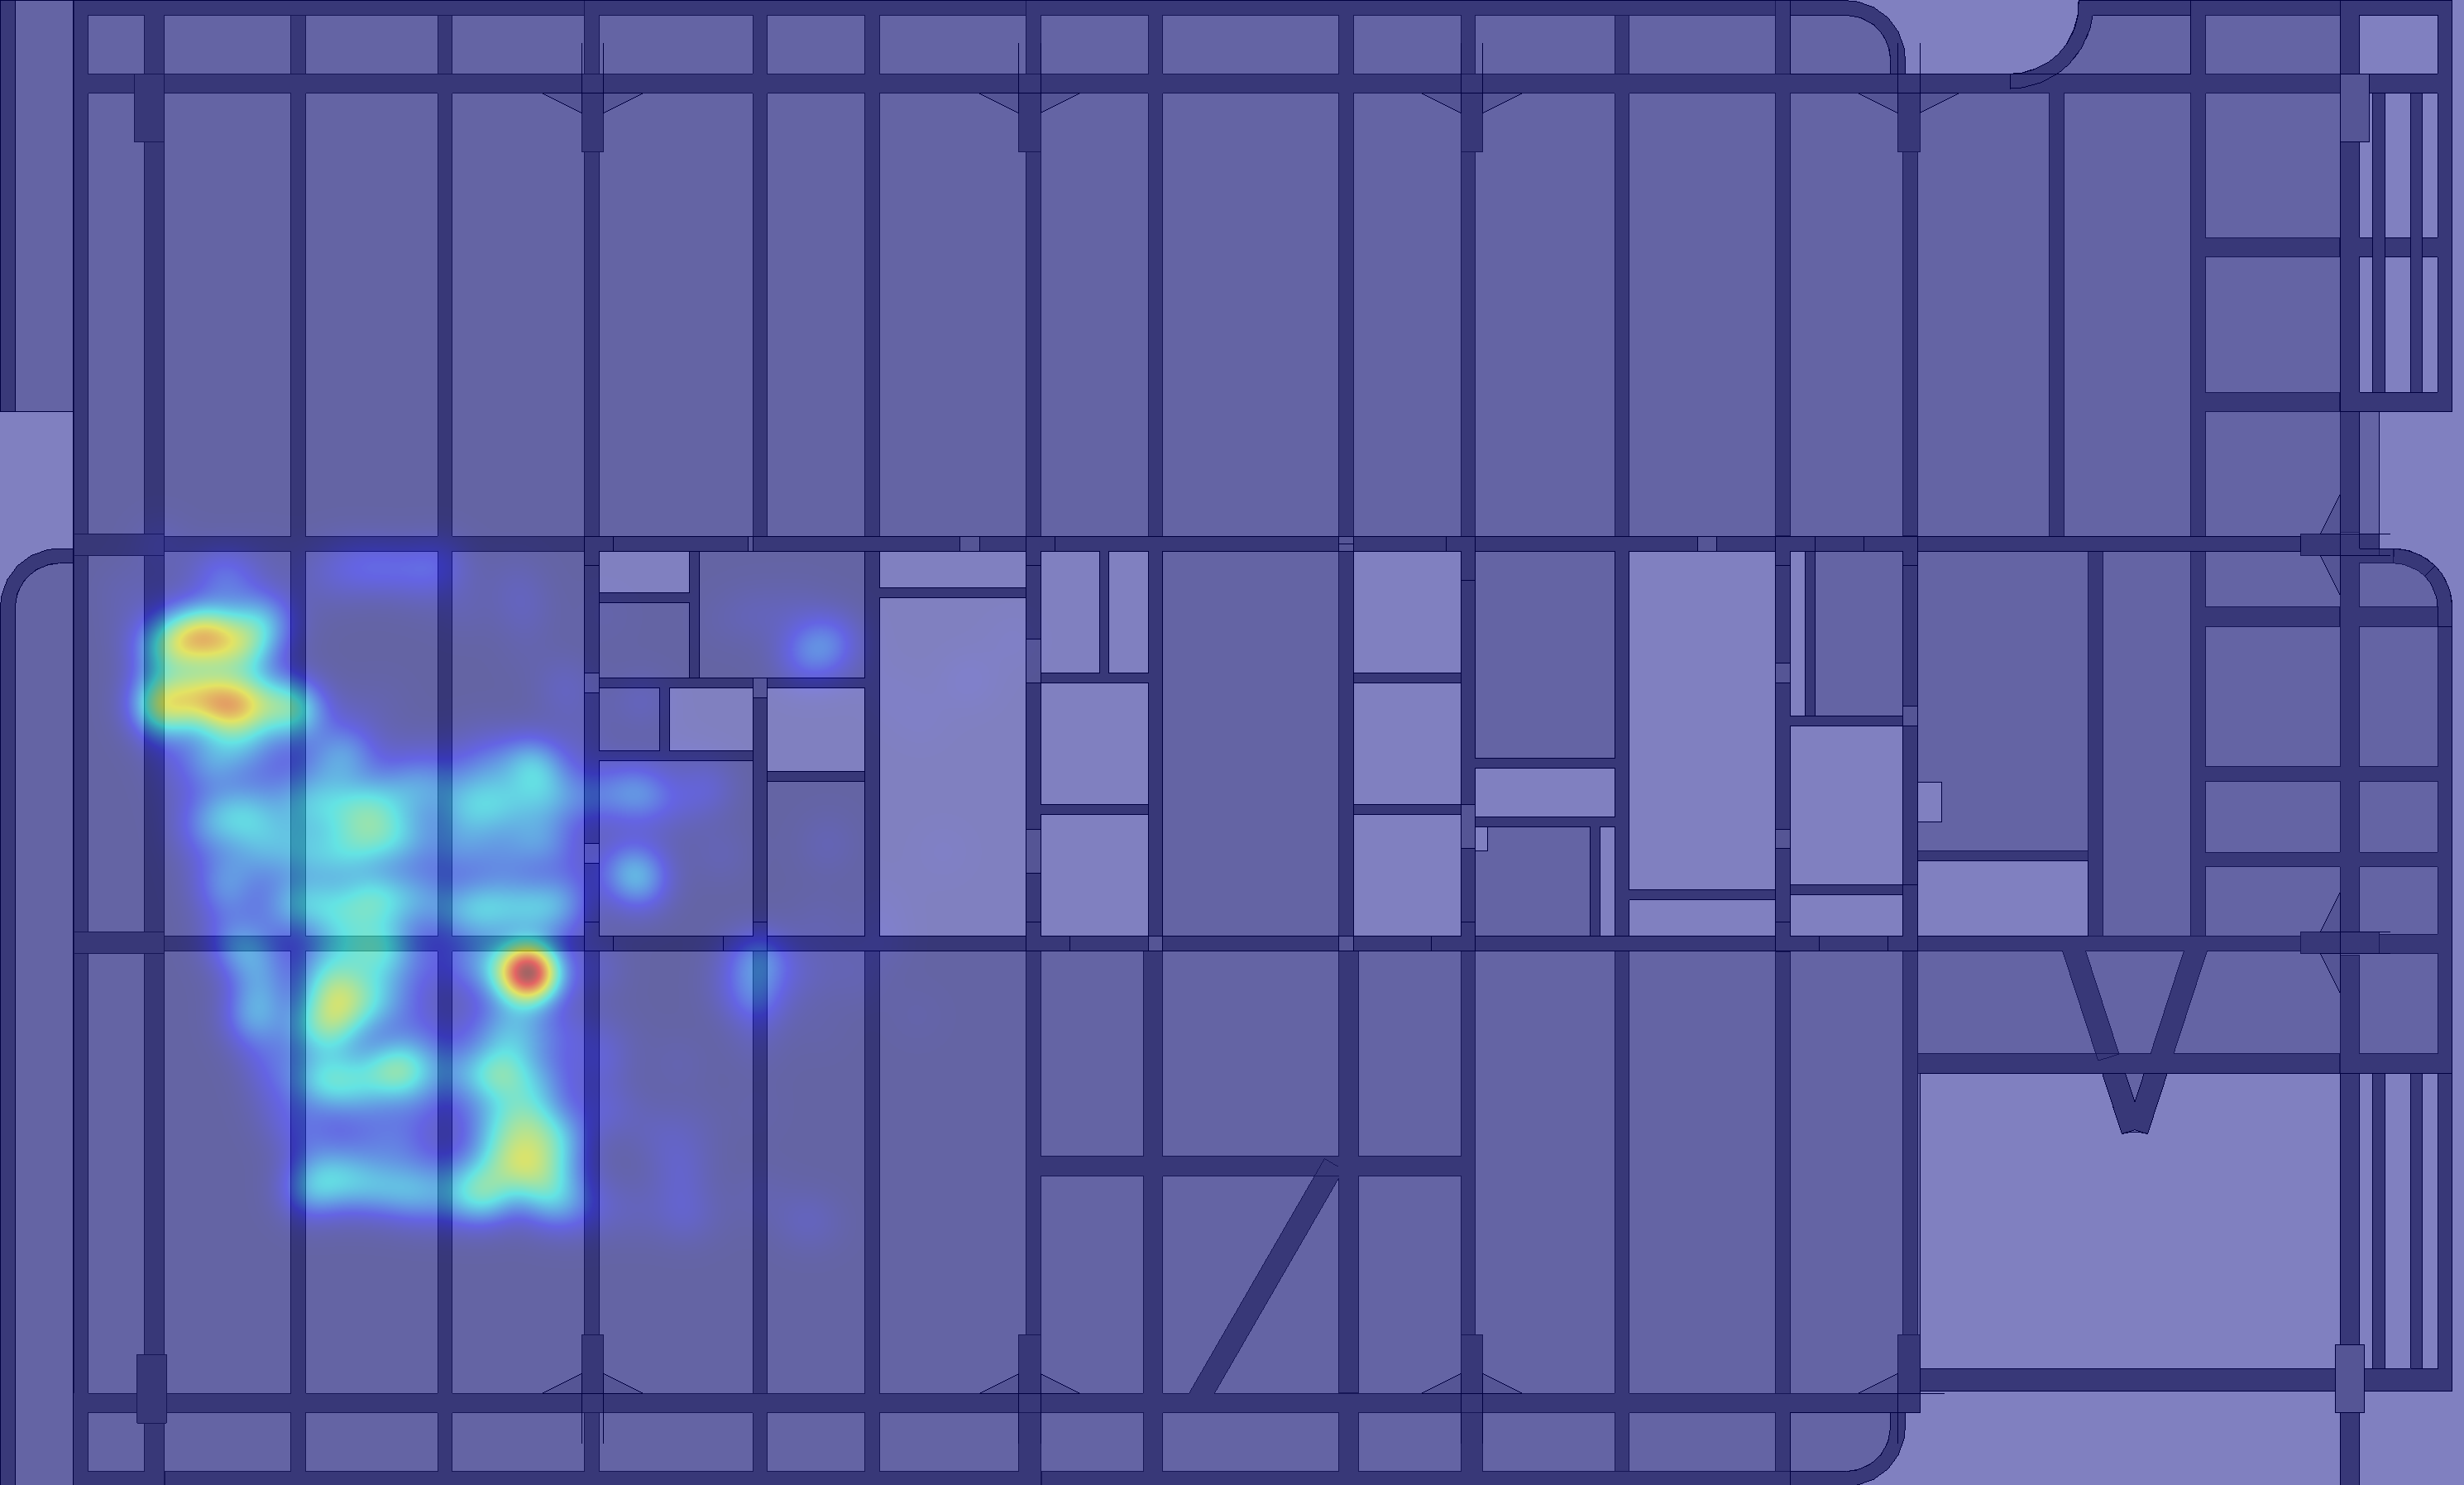

In [12]:
id=len(100)
pdm = PDM(density,alpha=1,frame_interval=100,T_need=30,sigma=25)
delta = Delta(img=bim_floor,shape=bim_floor.shape[:2],sigma=25)
delta.add_points_list(results[0:id-1])
map=delta.get_raw(masked=False,process=True)
pdm.update_map(map)
map=pdm.get_PDM(clip=True)
finished=pdm.get_flag()
time_consuming=[]
area=[]
productivity_area=[]
for mask in mask_list:
    time_consuming.append(np.sum(map*(mask>0)) * 4)
    area.append(np.sum(finished*(mask>0)))
    productivity_area.append(time_consuming[-1]/area[-1]*100)
heatmapshow=None
heatmapshow = cv2.normalize(map,heatmapshow, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
heatmapshow = cv2.applyColorMap(heatmapshow, cv2.COLORMAP_JET)
fusion=cv2.addWeighted(heatmapshow,0.5,bim_floor,0.5,1)
fusion=cv2.cvtColor(fusion,cv2.COLOR_BGR2RGB)
Image.fromarray(fusion)

ValueError: 1050.0 is not in list

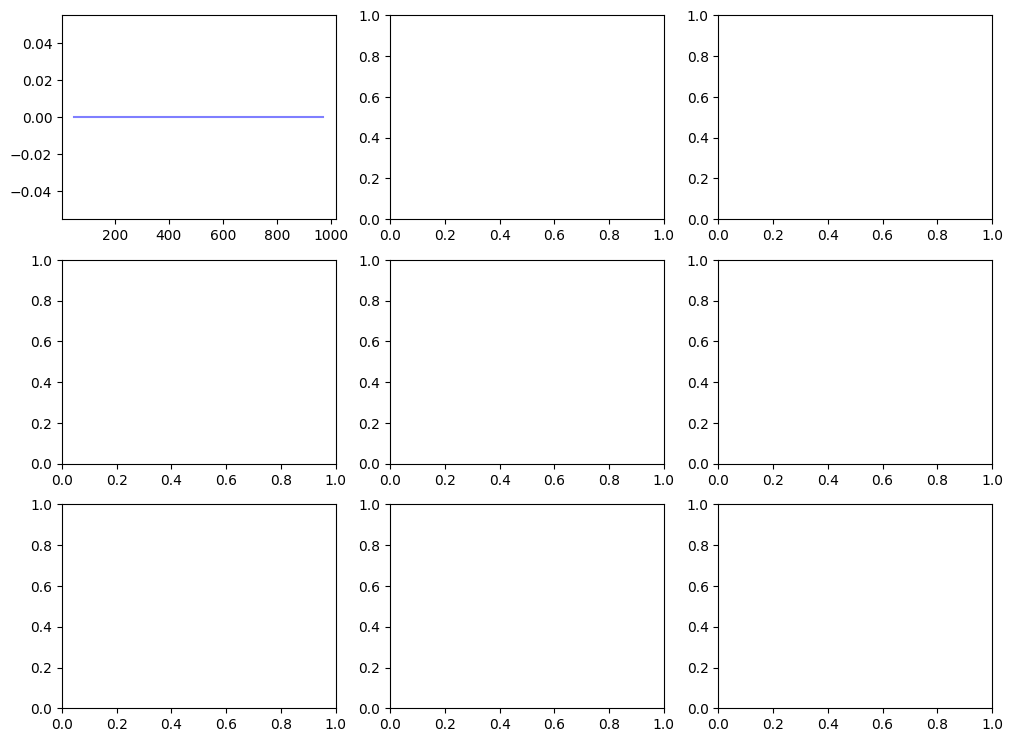

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# 子图的行数和列数
rows = 3
cols = 3

# 每个子图的大小
subplot_width = 4
subplot_height = 3

# 计算整张图的大小
fig_width = cols * subplot_width
fig_height = rows * subplot_height

# 创建一个包含多个子图的图像，并设置大小
fig, axs = plt.subplots(rows, cols, figsize=(fig_width, fig_height))

# 通过循环在每个子图中绘制内容
for i in range(len(mask_list)):
    row = i // cols
    col = i % cols
    y = [pred[i] for pred in progress]
    axs[row, col].plot(x, y,alpha=0.5,color="blue")
    sc_x=[i/100 for i in gt_list[i].keys()]
    sc_y=list(gt_list[i].values())
    mae=0
    mre=0
    count=0
    for si in range(len(sc_x)):
        gt=sc_y[si]
        pred=y[x.index(sc_x[si])]
        mae += abs(gt - pred)
        if gt != 0:
            mre += abs((gt - pred) / gt)
            count += 1
    mae /= len(sc_x)
    mre /= count if count > 0 else 1 
    axs[row, col].scatter(sc_x,sc_y,alpha=0.7,color="red",s=10,marker="x")
    axs[row, col].set_ylim([0, 1])
    axs[row, col].set_title(f"Slab {i+1} (MAE={mae:.2f})")
plt.tight_layout()
fig.legend(['True Progress', 'Estimated Progress'], loc='upper center', bbox_to_anchor=(0.5, 0.02), fancybox=False, shadow=False, ncol=2, fontsize='x-large')
plt.draw()
# plt.show()
# plt.savefig("/home/gaobiaoli/dataset/result/heat_map/progress.png",dpi=1000,bbox_inches='tight')
